<a href="https://colab.research.google.com/github/Mmariam2001/Mental-Health-Assistant-using-BERT/blob/main/Task_Assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers torch scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.8 MB/s eta 0:00:00


In [3]:
#Load and Explore the dataset
import json

# Load the JSON file
with open('intents.json') as f:
    data = json.load(f)

# See what the structure looks like
import pprint
pprint.pprint(list(data.items())[:2])

[('intents',
  [{'patterns': ['Hi',
                 'Hey',
                 'Is anyone there?',
                 'Hi there',
                 'Hello',
                 'Hey there',
                 'Howdy',
                 'Hola',
                 'Bonjour',
                 'Konnichiwa',
                 'Guten tag',
                 'Ola'],
    'responses': ['Hello there. Tell me how are you feeling today?',
                  'Hi there. What brings you here today?',
                  'Hi there. How are you feeling today?',
                  'Great to see you. How do you feel currently?',
                  "Hello there. Glad to see you're back. What's going on in "
                  'your world right now?'],
    'tag': 'greeting'},
   {'patterns': ['Good morning'],
    'responses': ["Good morning. I hope you had a good night's sleep. How are "
                  'you feeling today? '],
    'tag': 'morning'},
   {'patterns': ['Good afternoon'],
    'responses': ['Good afternoon. How i

In [4]:
#Convert it into datafram
import pandas as pd

df = pd.DataFrame(data)
df.head()

,intents
0,"{'tag': 'greeting', 'patterns': ['Hi', 'Hey', ..."
1,"{'tag': 'morning', 'patterns': ['Good morning'..."
2,"{'tag': 'afternoon', 'patterns': ['Good aftern..."
3,"{'tag': 'evening', 'patterns': ['Good evening'..."
4,"{'tag': 'night', 'patterns': ['Good night'], '..."


In [5]:
# Expand the 'intents' column
intents = df['intents'].apply(pd.Series)

# Create a new DataFrame with 'text' and 'label'
rows = []
for _, row in intents.iterrows():
    tag = row['tag']
    patterns = row['patterns']
    for pattern in patterns:
        rows.append({"text": pattern, "label": tag})

train_df = pd.DataFrame(rows)
train_df.head()

,text,label
0,Hi,greeting
1,Hey,greeting
2,Is anyone there?,greeting
3,Hi there,greeting
4,Hello,greeting


In [5]:
# STEP2 Tokenize with HuggingFace Transformers
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [6]:
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizerFast

# Encode labels to integers
le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['label'])


<Axes: title={'center': 'Samples per Intent'}, xlabel='label_encoded'>

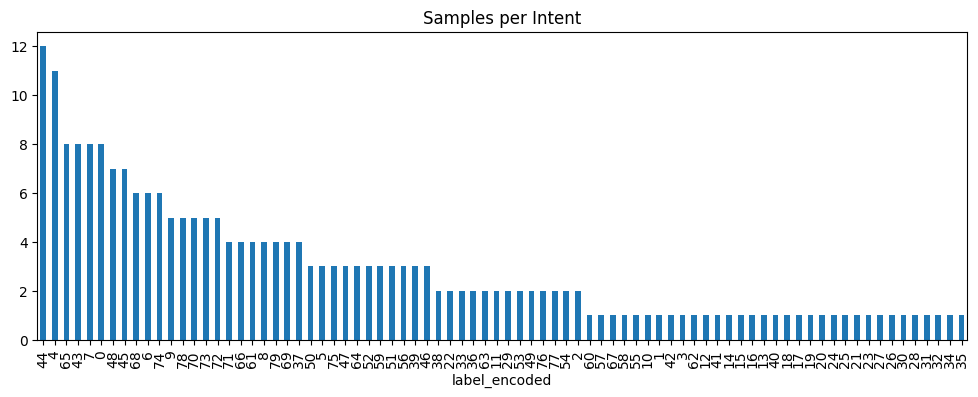

In [7]:
#To See How Many Samples per Intent
train_df['label_encoded'].value_counts().plot(kind='bar', figsize=(12,4), title='Samples per Intent')

In [9]:
# Count label frequencies
label_counts = train_df['label_encoded'].value_counts()

# Keep only labels with 2 or more examples
filtered_df = train_df[train_df['label_encoded'].isin(label_counts[label_counts >= 2].index)]

In [10]:
# This will make sure the test set has at least 47 samples bc i got error since my dataset is small
from sklearn.model_selection import train_test_split
# Split the data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    filtered_df['text'],
    filtered_df['label_encoded'],
    test_size=0.4,  # or try 0.4 if you want to be safe
    random_state=42,
    stratify=filtered_df['label_encoded']
)

<Axes: title={'center': 'Samples per Intent'}, xlabel='label_encoded'>

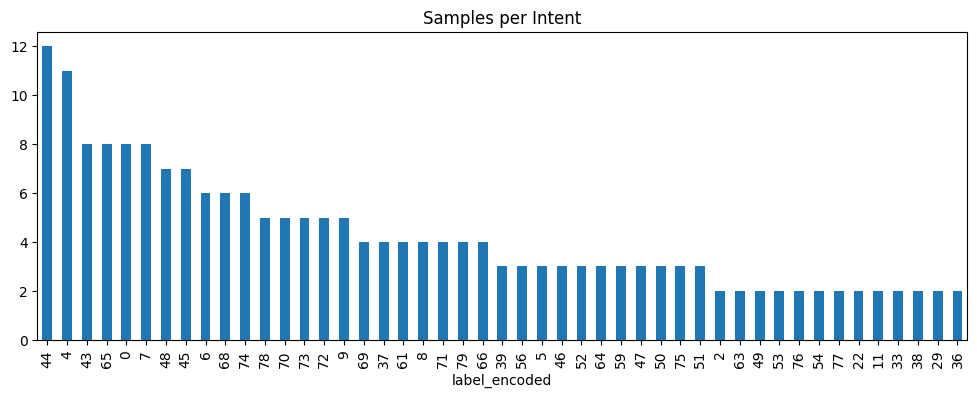

In [11]:
#To See How Many Samples per Intent
filtered_df['label_encoded'].value_counts().plot(kind='bar', figsize=(12,4), title='Samples per Intent')

In [12]:
# Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('bert-base-uncased')
# distilbert has 66M parameter
# with 6 layers (half of BERT)

# Tokenize the text
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizerFast'.


In [13]:
import torch # required for building deep learning models

class IntentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Return a single sample (dict)
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create the dataset
train_dataset = IntentDataset(train_encodings, list(train_labels))
test_dataset = IntentDataset(test_encodings, list(test_labels))

In [18]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(le.classes_)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
!pip install --upgrade transformers

In [44]:
!pip install --upgrade transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is i

In [63]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


training_args = TrainingArguments(
    output_dir="./results",
    #evaluation_strategy="epoch",  # requires latest transformers
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=23,
    logging_dir="./logs",
    logging_steps=10,
    learning_rate=3e-5,
    gradient_accumulation_steps = 3,
    metric_for_best_model="eval_loss"
)


In [64]:
from sklearn.metrics import accuracy_score

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

In [65]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [66]:
!wandb login b63c08dede6961f75a730c4e20062c34d30de912
trainer.train()

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,0.313800
20,0.273500
30,0.230100
40,0.235000


TrainOutput(global_step=46, training_loss=0.2583439298298048, metrics={'train_runtime': 583.6212, 'train_samples_per_second': 4.69, 'train_steps_per_second': 0.079, 'total_flos': 24508063210176.0, 'train_loss': 0.2583439298298048, 'epoch': 15.375})

In [67]:
trainer.evaluate()

{'eval_loss': 1.2541141510009766,
 'eval_accuracy': 0.725,
 'eval_runtime': 7.7936,
 'eval_samples_per_second': 10.265,
 'eval_steps_per_second': 0.257,
 'epoch': 15.375}

In [68]:
#Make Predictions
def predict_intent(message):
    # Tokenize the new message
    encoding = tokenizer(message, truncation=True, padding=True, return_tensors='pt')

    # Get the model's prediction
    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits

    # Get the predicted class (highest logit)
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Decode the predicted class to its intent label
    predicted_intent = le.inverse_transform([predicted_class])[0]
    return predicted_intent

In [69]:
# Example messages
messages = [
    "Hello, how are you?",
    "I'm feeling down today.",
    "Good morning, everyone!",
    "I'm not sure what to do."
]

# Predict the intent for each message
for msg in messages:
    print(f"Message: {msg} | Predicted Intent: {predict_intent(msg)}")

Message: Hello, how are you? | Predicted Intent: about
Message: I'm feeling down today. | Predicted Intent: sad
Message: Good morning, everyone! | Predicted Intent: goodbye
Message: I'm not sure what to do. | Predicted Intent: worthless


In [72]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(dataset):
    # Prepare the inputs and labels
    inputs = [tokenizer(text, truncation=True, padding=True, return_tensors='pt') for text in train_df['text']]
    labels = train_df['label_encoded'].tolist()

    # Make predictions for all inputs
    predictions = []
    for encoding in inputs:
        with torch.no_grad():
            outputs = model(**encoding)
            logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item()
        predictions.append(predicted_class)

    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)
    print(f"Accuracy: {accuracy}")

    # Detailed classification report (precision, recall, F1-score)
    print("\nClassification Report:")
    print(classification_report(labels, predictions, target_names=le.classes_))

# Evaluate the model
evaluate_model(dataset)

NameError: name 'dataset' is not defined

In [74]:
intent_responses = {
    "greeting": "Hey there! How can I help you today? 😊",
    "sadness": "I'm really sorry you're feeling this way. Want to talk about it?",
    "happy": "That's great to hear! Tell me more!",
    "morning": "Good morning! Hope you slept well!",
    "evening": "Good evening! How was your day?",
    "thanks": "You're very welcome! 🙏",
    "default": "I'm not sure I understand. Could you rephrase that?"
}

In [75]:
def chatbot_response(user_input):
    intent = predict_intent(user_input)  # Predict the intent from the message
    response = intent_responses.get(intent, intent_responses["default"])
    return response

In [77]:

while True:
    user_input = input("You: ")
    if user_input.lower() in ['quit', 'exit']:
        print("Bot: Goodbye! 👋")
        break
    print("Bot:", chatbot_response(user_input))

You: What's the difference between sadness and depression?
Bot: I'm not sure I understand. Could you rephrase that?
You: What's the difference between anxiety and stress?
Bot: I'm not sure I understand. Could you rephrase that?
You: please exit
Bot: I'm not sure I understand. Could you rephrase that?
You: Quit
Bot: Goodbye! 👋
